<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Мне предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

В исследовании необходимо построить модель с предельно большим значением *F1*-меры. Согласно поставленной задаче, нужно довести метрику до 0.59, а также проверить *F1*-меру на тестовой выборке. Помимо этого, я буду измерять *AUC-ROC*, сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем библиотеки, которые понадобятся для исследования:

In [1]:
import pandas as pd

import math

import sklearn

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve 

from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, recall_score

from sklearn import svm, datasets

from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score

from sklearn.utils import resample

from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV 

from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV

Познакомимся с данными и сохраним их в переменную df:

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

Проверим информацию о датасете и выведем на экран первые пять строк:

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В целом, данные в порядке. Но мы видим, что столбец Tenure — сколько лет человек является клиентом банка - имеет пропуски.  

Можно предположить, что период исчесляется в годах и тогда клиенты которые пользуются услугами банка несколько месяцев отмечены пропуском, но это вряд ли соответствует действительности, так как столбец Tenure - имеет тип float64, то есть плавающая запятая позволяет нам указать неполный год.  

Таким образом пока допустим, что это ошибка означает, что при заполнении данные не были добавлены. Количество пропусков составляет примерно 10% от общего. 

Мы можем применить несколько способов очистки данных, например:

* Удалить объекты с пропусками
* Заменить значение пропусков на медиану
* Заменить значения пропусков на ноль

Но в данном случае, я применю способ замены пропусков на ноль. Учитывая относительно небольшое количество пропусков. И сразу изменю тип данных на целое число.

In [4]:
df['Tenure'] = df['Tenure'].fillna(0)

df['Tenure'] = df['Tenure'].astype('int64') #и меняем тип

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Удалим из датафрейма столбцы Surname и RowNumber, которые не влияют на результат исследования, но их наличие только усложнит модель.

In [5]:
df = df.drop(['Surname','RowNumber','CustomerId'],axis=1)

Преобразуем категориальные признаки в количественные с помощью техники прямого кодирования (OHE), в этом поможет метод .get_dummies, это нужно чтобы не попасть в  дамми-ловушку, когда фиктивных признаков слишком много.

Теперь разделим датафрейм на features и target - целевой признак, а потом разделим датафрейм на обучающую выборку, валидационную выборку и тестовую выборку



In [6]:
target = df['Exited']
features = df.drop('Exited', axis=1)

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)


features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345, stratify=target_train_valid)

In [7]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

В нашей таблице есть, например, столбцы Age и EstimatedSalary, показатели в столбцах и их разброс очень отличаются, алгоритм может решить, что данные EstimatedSalary важнее чем возраст клиентов и произойдет скос результатов.

Чтобы этого избежать мы применим метод масштабирования - стандартизация данных.

In [8]:
#выберем признаки для масштабирования:
pd.options.mode.chained_assignment = None

numeric = ['CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Вывод по первому пункту исследования:

* Были проверены представленные данные, на типы и пропуски
* Были удалены столбцы не влияющие на исследование
* Категориальные и количественные признаки были преобразованы с помощью техники OHE (One-Hot Encoding)
* Было проведено масштабирование признаков, для того чтобы алгоритм не выделял один признак приоритетнее прочих


## Исследование задачи

Для начала проверим адекватности модели. Чтобы оценить адекватность модели, узнаем, как часто в целевом признаке встречается класс «1» или «0». Количество уникальных значений подсчитывается методом value_counts(). 
Он группирует строго одинаковые величины.


0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

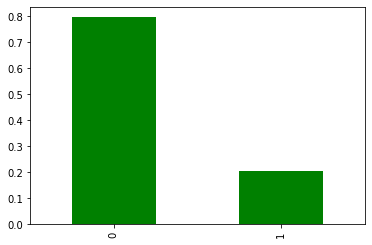

In [10]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar',color ='green')

На графике мы видим, что около 80% клиентов не уходят из банка. Это неплохо для Банка, но не подходит для обучения модели - создаст дисбаланс.

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем — AUC-ROC. Это метрика качества, которая изменяется от 0 до 1. AUC-ROC случайной модели равна 0.5.

Сравним результаты:

* Случайного дерева
* Дерева принятия решений

In [11]:
model_DT_1 = DecisionTreeClassifier(random_state = 12345,criterion='gini')
model_DT_1.fit(features_train, target_train)

probabilities_valid = model_DT_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_dt = roc_auc_score(target_valid,probabilities_one_valid)

In [12]:
model_RF_1 = RandomForestClassifier(random_state = 12345, n_estimators = 101)
model_RF_1.fit(features_train, target_train)

probabilities_valid = model_RF_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_rf = roc_auc_score(target_valid,probabilities_one_valid)


AUC-ROC дерева принятия решений: 0.6827906488923438
AUC-ROC случайного леса: 0.8520870639514707


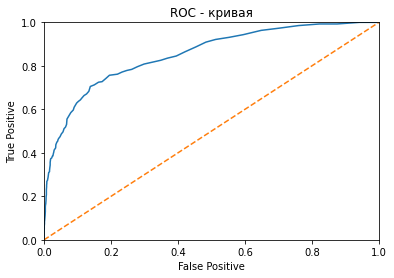

In [13]:
fpr, tpr, thresholds = roc_curve(target_valid,probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive')
plt.ylabel('True Positive')

plt.title('ROC - кривая')
plt.show


print('AUC-ROC дерева принятия решений:', auc_roc_dt )
 

print('AUC-ROC случайного леса:', auc_roc_rf )
 

# Вывод по второму пункту исследования:  

* Проведена оценка целевого признака и выявлен дисбаланс  
* Матрица ошибок указывает на значительное количество ошибок в пробной модели
* Мы испробовали методы:

- Дерева принятия решений - и получили результат 0.6107559867779601 - неплохо, но этот метод не является самым точным
- Случайного леса - и получили результат 0.43645335426030296 - значительно ниже, чем нам нужно. Основная идея метода, заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим. 
- Логистической регрессии - где получили результат 0.5635780361941451 - этот метод был добавлен скорее для некоторого усредненного ориентирования в обстановке.  

Таким образом ориентируясь на показатели Случайного леса, как на наиболее достоверные принемаем решение избавиться от дисбаланса и заново обучим модель.

## Борьба с дисбалансом

Поскольку мы знаем что у нас присутсвуют обьекты редкого класса, из-за чего возникает дисбаланс, попробуем придать им больший вес в алгоритме.  

Проверим что изменится применяя метод на использованных ранее способах.

In [14]:
#первым возьмем дерево решений:

model_DT_1 = DecisionTreeClassifier(random_state = 12345, class_weight='balanced' )
model_DT_1.fit(features_train, target_train)

predicted_valid = model_DT_1.predict(features_valid)

print('У Дерева решений F1:', f1_score(target_valid,predicted_valid))
print('А Accuracy:', accuracy_score(target_valid, predicted_valid))

У Дерева решений F1: 0.49215922798552475
А Accuracy: 0.7895


In [15]:
#далее возьмем случайный лес:

model_RF_1 = RandomForestClassifier(random_state = 12345, class_weight='balanced' )
model_RF_1.fit(features_train, target_train)

predicted_valid = model_RF_1.predict(features_valid)

print('У Случайного леса F1:', f1_score(target_valid,predicted_valid))
print('А Accuracy:', accuracy_score(target_valid, predicted_valid))

У Случайного леса F1: 0.558641975308642
А Accuracy: 0.857


F1 имеет низкий показатель у Дерева решений и Случайного леса. Применим дополнительные меры для устранения дисбаланса.

# Изменим результат выборки и посмотрим на результат

Увеличим выборку. То есть сделаем объекты редкого класса более значительными для модели.

In [16]:
def upsample(features, target,repeat):    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [17]:
model_DT_1 = DecisionTreeClassifier(random_state = 12345)
model_DT_1.fit(features_upsampled, target_upsampled)

predicted_valid = model_DT_1.predict(features_valid)

print('Теперь у Дерева решений F1:', f1_score(target_valid, predicted_valid))
print('А Accuracy:', accuracy_score(target_valid, predicted_valid))

Теперь у Дерева решений F1: 0.4826732673267327
А Accuracy: 0.791


In [18]:
model_RF_1 = RandomForestClassifier(random_state = 12345, n_estimators = 120, max_depth = 12)
model_RF_1.fit(features_upsampled, target_upsampled)

predicted_valid = model_RF_1.predict(features_valid)

print('Теперь у Случайного леса F1:', f1_score(target_valid, predicted_valid))
print('А Accuracy:', accuracy_score(target_valid, predicted_valid))

Теперь у Случайного леса F1: 0.6306954436450839
А Accuracy: 0.846




# Попробуем уменьшить выборку. 

Вместо повторения важных вопросов убрем часть неважных.

In [19]:
def downsample(features, target,fraction):    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac = fraction, random_state = 12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac = fraction, random_state = 12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state = 12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

In [20]:
model_DT_2 = DecisionTreeClassifier(random_state = 12345)
model_DT_2.fit(features_downsampled, target_downsampled)

predicted_valid = model_DT_2.predict(features_valid)

print('Теперь у Дерева решений F1:', f1_score(target_valid, predicted_valid))
print('А Accuracy:', accuracy_score(target_valid, predicted_valid))


# сохраним результат как новую переменную

Теперь у Дерева решений F1: 0.46720575022461813
А Accuracy: 0.7035


In [21]:
model_RF_2 = RandomForestClassifier(random_state = 12345, n_estimators = 150, max_depth = 12)
model_RF_2.fit(features_downsampled, target_downsampled)

predicted_valid = model_RF_2.predict(features_valid)

print('Теперь у Случайного леса F1:', f1_score(target_valid, predicted_valid))
print('А Accuracy:', accuracy_score(target_valid, predicted_valid))


# сохраним результат как новую переменную

Теперь у Случайного леса F1: 0.635593220338983
А Accuracy: 0.828


In [22]:
param_grid = {
    'n_estimators': list(np.arange(2, 151, 2).astype(int)),
    'max_depth': [None] + list(np.arange(2,13,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

estimator = RandomForestClassifier(random_state = 12345)

model = RandomizedSearchCV(estimator, param_grid, cv=4, scoring = 'f1')

model.fit(features_train, target_train)

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 2, 4, 6, 8, 10, 12],
                                        'max_features': ['auto', 'sqrt', None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90,
                                                           100],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [2, 4, 6, 8, 10, 12, 14,
                                                         16, 18, 20, 22, 24, 26,
                                                         28, 30, 32, 34, 36, 38,
                                                         40, 42, 44, 46, 48, 50,
                                                         52, 54, 56, 5

In [23]:
print('Среднее значение F1 по выборкам:', model.best_score_)

Среднее значение F1 по выборкам: 0.5341911014061552


Результат лучше при увеличении выборки. Поработаем и дальше с Логистической регрессей, которая дает сомнительный результат и со Случайным лесом, который дал лучший результат в F1

## Тестирование модели

In [24]:
# тестируем первый вариант Случайного леса, где мы присвоили вес классу:

predictions = model_RF_1.predict(features_valid)

probabilities_valid = model_RF_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Результат F1 для модели Случайного леса стал:',f1_score(target_valid, predictions))
print('Результат AUC - ROC  для модели Случайного леса стал:',roc_auc_score(target_valid,probabilities_one_valid))

Результат F1 для модели Случайного леса стал: 0.6306954436450839
Результат AUC - ROC  для модели Случайного леса стал: 0.862352336928608


In [25]:
# тестируем первый вариант Дерева решений, где мы уменьшили выборку:

predictions = model_DT_1.predict(features_valid)

probabilities_valid = model_DT_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Результат F1 для модели Дерева решений стал:',f1_score(target_valid, predictions))
print('Результат AUC - ROC  для модели Дерева решений стал:',roc_auc_score(target_valid,probabilities_one_valid))

Результат F1 для модели Дерева решений стал: 0.4826732673267327
Результат AUC - ROC  для модели Дерева решений стал: 0.6748998613405393


И если модель Дерева решений улучшилась в F1-метрике, то модель Случайного леса все равно не дотягивает в F1 - метрике.

# Пробуем следующие варианты, где мы меняли порог классификации:

In [26]:
predictions = model_RF_2.predict(features_valid)

probabilities_valid = model_RF_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Результат F1 для модели Случайного леса стал:',f1_score(target_valid, predictions))
print('Результат AUC - ROC  для модели Случайного леса стал:',roc_auc_score(target_valid,probabilities_one_valid))

Результат F1 для модели Случайного леса стал: 0.635593220338983
Результат AUC - ROC  для модели Случайного леса стал: 0.8673897317965114


In [27]:
predictions = model_DT_2.predict(features_valid)

probabilities_valid = model_DT_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Результат F1 для модели Дерева решений стал:',f1_score(target_valid, predictions))
print('Результат AUC - ROC  для модели Дерева решений стал:',roc_auc_score(target_valid,probabilities_one_valid))

Результат F1 для модели Дерева решений стал: 0.46720575022461813
Результат AUC - ROC  для модели Дерева решений стал: 0.6794228743381285


Выбираем модель Случайного леса с F1-метрикой 0.63 что выше заданного минимального порога 0.59